In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# re-defining class for loading weights from saved file
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 3)
        self.fc1 = nn.Linear(4608, 1024)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(1024, 256)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 36)
        
    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, 4608)
        x = self.dropout1(F.relu(self.fc1(x)))
        x = self.dropout2(F.relu(self.fc2(x)))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return F.log_softmax(x)
    
model = Net()
# loading pre-trained weights into the model
model.load_state_dict(torch.load('../models/model.pt', map_location=torch.device('cpu')))
# switching from training mode to testing mode
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=4608, out_features=1024, bias=True)
  (dropout1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=1024, out_features=256, bias=True)
  (dropout2): Dropout(p=0.3, inplace=False)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=36, bias=True)
)

In [4]:
from pytorch_model_summary import summary
# printing keras-style model summary
print(summary(Net(), torch.zeros((1, 1, 28, 28))))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
          Conv2d-1     [1, 32, 24, 24]             832             832
       MaxPool2d-2     [1, 32, 12, 12]               0               0
          Conv2d-3       [1, 64, 8, 8]          51,264          51,264
          Conv2d-4      [1, 128, 6, 6]          73,856          73,856
          Linear-5           [1, 1024]       4,719,616       4,719,616
         Dropout-6           [1, 1024]               0               0
          Linear-7            [1, 256]         262,400         262,400
         Dropout-8            [1, 256]               0               0
          Linear-9            [1, 128]          32,896          32,896
         Linear-10             [1, 36]           4,644           4,644
Total params: 5,145,508
Trainable params: 5,145,508
Non-trainable params: 0
-----------------------------------------------------------------------

In [12]:
df1 = pd.read_csv('../inputs/mnist_train.csv')
df2 = pd.read_csv('../inputs/mnist_test.csv')

In [13]:
df1.head()

,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df2.head()

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
# NOTE: ensure that dataset is downloaded and placed in 'inputs' folder before running this cell
def read_data(path):
    data = []
    labels = []
    
    for row in open(path):
        row = row.split(',')
        label = int(row[0])
        image = np.array([int(x) for x in row[1:]], dtype="uint8")
        
        image = image.reshape((28, 28))
        
        data.append(image)
        labels.append(label)
        
    data = np.array(data, dtype="float32")
    labels = np.array(labels, dtype="int")
    
    return data, labels

alphabets, labels_alphabets = read_data("../inputs/A_Z Handwritten Data.csv")
labels_alphabets += 10

digits_train, labels_digits_train = read_data("../inputs/mnist_train.csv")
digits_test, labels_digits_test = read_data("../inputs/mnist_test.csv")
digits = np.vstack([digits_train, digits_test])
labels_digits = np.hstack([labels_digits_train, labels_digits_test])

In [17]:
labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K',
         'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

In [18]:
# function to test the model on a single image of an alphabet with index 'idx' in the dataset
def test_alphabets(idx):
    print("Actual image:")
    plt.imshow(alphabets[idx], cmap='gray')
    plt.show()
    print(f"Actual label: {labels[labels_alphabets[idx]]}")
    # defining same transformations as done while training the mdoel
    transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))]
        )
    # preprocessing the image
    input_image = alphabets[idx] / 255.0
    input_image = transform(input_image)
    # obtaining output of the model; an extra dimension is first added to the image to represent batch size of 1
    output = model(input_image.unsqueeze(0))
    # taking maximum of log-likelihoods for the prediction
    pred = output.data.max(1, keepdim=True)[1]
    print(f"Predicted label: {labels[pred[0][0]]}")
    
# function to test the model on a single image of a digit with index 'idx' in the dataset
def test_digits(idx):
    print("Actual image:")
    plt.imshow(digits[idx], cmap='gray')
    plt.show()
    print(f"Actual label: {labels[labels_digits[idx]]}")
    transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))]
        )
    input_image = digits[idx] / 255.0
    input_image = transform(input_image)
    output = model(input_image.unsqueeze(0))
    pred = output.data.max(1, keepdim=True)[1]
    print(f"Predicted label: {labels[pred[0][0]]}")

Actual image:


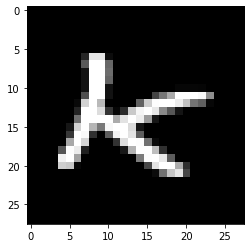

Actual label: K
Predicted label: K


In [19]:
test_alphabets(91512)

Actual image:


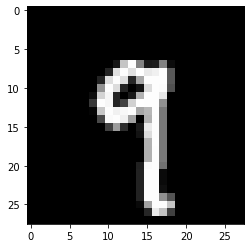

Actual label: 9
Predicted label: 9


In [20]:
test_digits(176)

In [21]:
# function to obtain training accuracy on the entire alphabets dataset; can be improved by DataLoaders
# WARNING: this cell can take considerable time to run since it processes more than 4 lakh images
def alphabets_accuracy():
    count = 0
    for idx in range(len(alphabets)):
        # image pre-processing
        transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))]
        )
        input_image = alphabets[idx] / 255.0
        input_image = transform(input_image)
        # obtaining output (log-likelihoods)
        output = model(input_image.unsqueeze(0))
        # making prediction by taking maximum of log-likelihoods
        pred = output.data.max(1, keepdim=True)[1]
        if pred[0][0] == labels_alphabets[idx]:
            count += 1
    accuracy = count * 100 / len(alphabets)
    return accuracy

In [22]:
accuracy_alphabets = alphabets_accuracy()
print(f"Training accuracy on alphabets: {accuracy_alphabets}")

Training accuracy on alphabets: 98.84333778134574


In [23]:
# function to obtain training accuracy on the entire digits dataset
def digits_accuracy():
    count = 0
    for idx in range(len(digits)):
        transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))]
        )
        input_image = digits[idx] / 255.0
        input_image = transform(input_image)
        output = model(input_image.unsqueeze(0))
        pred = output.data.max(1, keepdim=True)[1]
        if pred == labels_digits[idx]:
            count += 1
    
    accuracy = count * 100 / len(digits)
    return accuracy

In [24]:
accuracy_digits = digits_accuracy()
print(f"Training accuracy on digits: {accuracy_digits}")

Training accuracy on digits: 94.08285714285714


In [25]:
final_acc = (372450 * accuracy_alphabets + 60000 * accuracy_digits) / (372450 + 60000)
print(f"Overall training accuracy: {final_acc}")

Overall training accuracy: 98.18284792515584


# Testing on Custom_Images

In [26]:
import cv2

In [27]:
# function to test the model on a custom image
def predict_custom_image(path):
    img = cv2.imread(path)
    # converting RGB image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # blurring image if it is of an exceptionally high resolution
    if gray.shape[0] > 1500:
        gray = cv2.GaussianBlur(gray, (401, 401), 0)
    # resizing the image according to the requirements of the model
    small = cv2.resize(gray, (28, 28))
    # inverting colours to get black background
    small = cv2.bitwise_not(small)
    # converting image to pure black and white
    (thresh, small) = cv2.threshold(small, 127, 255, cv2.THRESH_BINARY)
    
    img_array = np.array(small, dtype=np.float32)
    
    plt.imshow(img_array, cmap="gray")
    plt.show()
    
    # image pre-processing 
    transform = transforms.Compose(
            [transforms.ToTensor(),
            transforms.Normalize((0.5), (0.5))]
            )
    input_image = img_array / 255.0
    input_image = transform(input_image)
    # getting output
    output = model(input_image.unsqueeze(0))
    # making prediction
    pred = output.data.max(1, keepdim=True)[1]
    return labels[pred]

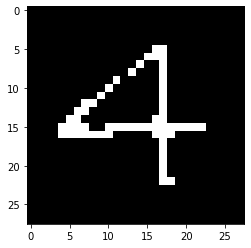

Predicted label : 4


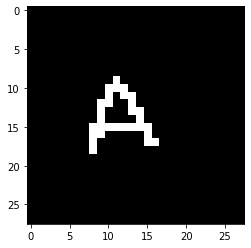

Predicted label : A


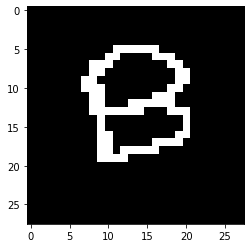

Predicted label : B


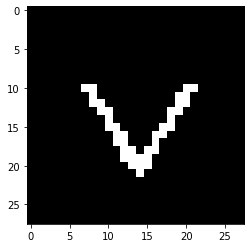

Predicted label : V


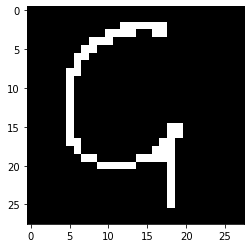

Predicted label : G


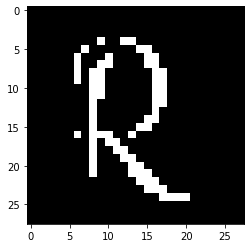

Predicted label : R


In [28]:
# defining image names as stored in 'custom_images' folder
img_names = ['4', 'A', 'B', 'V', 'G', 'R']
for img in img_names:
    PATH = f"../custom_images/{img}.jpg"
    pred = predict_custom_image(PATH)
    print(f"Predicted label : {pred}")